In [1]:
!nvidia-smi

Fri Sep 17 00:56:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.96       Driver Version: 471.96       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     37MiB /  2048MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
TEST_CSV_PATH = 'datasets/AgeDB/csv/AgeDB_final_1-101_class-97-label-0-96-final-with-solved-corrupted-files.csv'
IMAGE_PATH_TEST = 'E:/AgeDB-images-with-solved-corrupted-files/'

PATH = 'Models_and_Logs/Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-200-withourLRS'

RANDOM_SEED = 42
NUM_CLASSES = 97
BATCH_SIZE = 128
GRAYSCALE = False
NUM_WORKERS = 0

In [5]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'evaluation_AgeDB.log')

In [7]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'\n-------------------EVALUATION RESULTS---------------')

In [8]:
for entry in header:
  print(entry)




Last Run: 2021-09-17 00:56:44.303873+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Output Path: Models_and_Logs/Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-200-withourLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False

-------------------EVALUATION RESULTS---------------


In [9]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [10]:
df = pd.read_csv(TEST_CSV_PATH, index_col=1)
df

,file,label
age,,
35,0_MariaCallas_35_f.jpg,33
40,1_MariaCallas_40_f.jpg,38
28,10_MariaCallas_28_f.jpg,26
52,100_PaulAnka_52_m.jpg,50
1,1000_StephenHawking_1_m.jpg,0
...,...,...
54,9995_GlennClose_54_f.jpg,52
56,9996_GlennClose_56_f.jpg,54
58,9997_GlennClose_58_f.jpg,56


In [11]:
class AgeDBDataset(Dataset):
    """Custom Dataset for loading AgeDB face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label)
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels

    def __len__(self):
        return self.y.shape[0]

In [12]:
custom_transform_test = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop((224, 224)),
                                        transforms.ToTensor()])

test_dataset = AgeDBDataset(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH_TEST,
                              transform=custom_transform_test,
                              items = None
                            )

# Dataset Entity Distribution Analysis

In [13]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

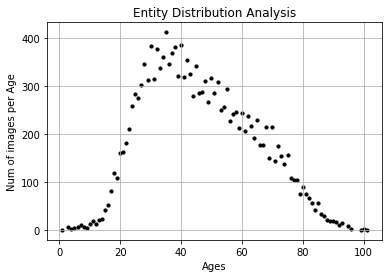

label		Age		Count
0 		 1 		 1
1 		 3 		 8
2 		 4 		 2
3 		 5 		 4
4 		 6 		 8
5 		 7 		 11
6 		 8 		 8
7 		 9 		 6
8 		 10 		 13
9 		 11 		 20
10 		 12 		 14
11 		 13 		 22
12 		 14 		 23
13 		 15 		 43
14 		 16 		 52
15 		 17 		 82
16 		 18 		 120
17 		 19 		 110
18 		 20 		 161
19 		 21 		 163
20 		 22 		 183
21 		 23 		 212
22 		 24 		 259
23 		 25 		 284
24 		 26 		 275
25 		 27 		 304
26 		 28 		 347
27 		 29 		 313
28 		 30 		 385
29 		 31 		 316
30 		 32 		 378
31 		 33 		 338
32 		 34 		 362
33 		 35 		 413
34 		 36 		 347
35 		 37 		 370
36 		 38 		 382
37 		 39 		 321
38 		 40 		 386
39 		 41 		 320
40 		 42 		 356
41 		 43 		 325
42 		 44 		 281
43 		 45 		 342
44 		 46 		 287
45 		 47 		 289
46 		 48 		 311
47 		 49 		 267
48 		 50 		 317
49 		 51 		 287
50 		 52 		 310
51 		 53 		 250
52 		 54 		 258
53 		 55 		 294
54 		 56 		 227
55 		 57 		 243
56 		 58 		 246
57 		 59 		 213
58 		 60 		 245
59 		 61 		 207
60 		 62 		 238
61 		 63 		 218
62 		 64 		 193
63 		 65 		 231

In [14]:
dataset_analysis(test_dataset)

# Dataset Loader

In [15]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [16]:
print(f"No. of Batches for AgeDB: {len(test_loader)}")

No. of Batches for AgeDB: 129


# Initialize Model, and Optimizer

In [17]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

"""Preparaing the model to evaluate on AgeDB"""
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 1, bias=False)
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float())

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Evaluation

In [18]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [19]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

In [20]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(tqdm(data_loader)):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

# Testing on AgeDB

In [21]:
lists = [i for i in range(1,201)] # number epochs to evaluate
result_dict = {}

start_time = time.time()
test_mae = test_mse = test_acc = 0.0
for i in tqdm(lists):
  model_name = f'Epoch_{i}_model.pt'
  model.load_state_dict(torch.load(os.path.join(PATH, model_name)))
  model.to(DEVICE)
  model.eval()

  with torch.set_grad_enabled(False):
    str0 = f'---------------{model_name}-----------------\n'
    print(str0)
    test_mae, test_mse, test_acc = compute_mae_and_mse(model, test_loader, device=DEVICE)
    
    result_dict[model_name] = test_mae    
    str1 = f'MAE/RMSE/ACC: | AGEDB-Test: {test_mae}/{test_mse}/{test_acc}%\n'
    str = str0+str1
    print(str1)
    with open(LOGFILE, 'a') as f: f.write(f'{str}\n')
    
time_elapsed = format((time.time() - start_time)/60, ".3f")
str = f'Time elapsed: {time_elapsed}mins\n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}')

  0%|          | 0/200 [00:00<?, ?it/s]

---------------Epoch_1_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

c:\users\sanaullapc\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


total_num_correct_preds: 26
MAE/RMSE/ACC: | AGEDB-Test: 34.012/36.948/0.158%

---------------Epoch_2_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 75
MAE/RMSE/ACC: | AGEDB-Test: 31.578/35.218/0.455%

---------------Epoch_3_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 122
MAE/RMSE/ACC: | AGEDB-Test: 27.120/30.889/0.740%

---------------Epoch_4_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 191
MAE/RMSE/ACC: | AGEDB-Test: 26.562/31.417/1.159%

---------------Epoch_5_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 191
MAE/RMSE/ACC: | AGEDB-Test: 26.034/30.848/1.159%

---------------Epoch_6_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 312
MAE/RMSE/ACC: | AGEDB-Test: 19.486/25.178/1.893%

---------------Epoch_7_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 246
MAE/RMSE/ACC: | AGEDB-Test: 25.999/32.451/1.493%

---------------Epoch_8_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 265
MAE/RMSE/ACC: | AGEDB-Test: 20.681/25.121/1.608%

---------------Epoch_9_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 381
MAE/RMSE/ACC: | AGEDB-Test: 17.063/22.267/2.312%

---------------Epoch_10_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 421
MAE/RMSE/ACC: | AGEDB-Test: 15.365/20.618/2.555%

---------------Epoch_11_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 301
MAE/RMSE/ACC: | AGEDB-Test: 17.595/21.771/1.827%

---------------Epoch_12_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 404
MAE/RMSE/ACC: | AGEDB-Test: 14.257/18.324/2.452%

---------------Epoch_13_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 359
MAE/RMSE/ACC: | AGEDB-Test: 16.847/21.320/2.179%

---------------Epoch_14_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 438
MAE/RMSE/ACC: | AGEDB-Test: 12.893/16.916/2.658%

---------------Epoch_15_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 430
MAE/RMSE/ACC: | AGEDB-Test: 13.720/17.441/2.610%

---------------Epoch_16_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 467
MAE/RMSE/ACC: | AGEDB-Test: 12.961/17.264/2.834%

---------------Epoch_17_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 493
MAE/RMSE/ACC: | AGEDB-Test: 12.676/16.863/2.992%

---------------Epoch_18_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 447
MAE/RMSE/ACC: | AGEDB-Test: 12.964/16.635/2.713%

---------------Epoch_19_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 470
MAE/RMSE/ACC: | AGEDB-Test: 12.370/15.907/2.852%

---------------Epoch_20_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 514
MAE/RMSE/ACC: | AGEDB-Test: 11.141/14.370/3.119%

---------------Epoch_21_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 460
MAE/RMSE/ACC: | AGEDB-Test: 12.519/16.018/2.792%

---------------Epoch_22_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 535
MAE/RMSE/ACC: | AGEDB-Test: 11.285/14.748/3.247%

---------------Epoch_23_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 456
MAE/RMSE/ACC: | AGEDB-Test: 12.593/16.141/2.767%

---------------Epoch_24_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 529
MAE/RMSE/ACC: | AGEDB-Test: 11.164/14.403/3.210%

---------------Epoch_25_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 556
MAE/RMSE/ACC: | AGEDB-Test: 10.173/12.965/3.374%

---------------Epoch_26_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 484
MAE/RMSE/ACC: | AGEDB-Test: 12.386/15.885/2.937%

---------------Epoch_27_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 476
MAE/RMSE/ACC: | AGEDB-Test: 12.756/16.191/2.889%

---------------Epoch_28_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 565
MAE/RMSE/ACC: | AGEDB-Test: 10.677/13.719/3.429%

---------------Epoch_29_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 553
MAE/RMSE/ACC: | AGEDB-Test: 10.116/12.966/3.356%

---------------Epoch_30_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 533
MAE/RMSE/ACC: | AGEDB-Test: 10.446/13.266/3.235%

---------------Epoch_31_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 577
MAE/RMSE/ACC: | AGEDB-Test: 10.358/13.307/3.502%

---------------Epoch_32_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 596
MAE/RMSE/ACC: | AGEDB-Test: 10.140/12.983/3.617%

---------------Epoch_33_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 539
MAE/RMSE/ACC: | AGEDB-Test: 9.953/12.785/3.271%

---------------Epoch_34_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 548
MAE/RMSE/ACC: | AGEDB-Test: 10.103/12.932/3.326%

---------------Epoch_35_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 550
MAE/RMSE/ACC: | AGEDB-Test: 9.746/12.489/3.338%

---------------Epoch_36_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 596
MAE/RMSE/ACC: | AGEDB-Test: 9.820/12.574/3.617%

---------------Epoch_37_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 569
MAE/RMSE/ACC: | AGEDB-Test: 9.959/12.791/3.453%

---------------Epoch_38_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 545
MAE/RMSE/ACC: | AGEDB-Test: 10.039/12.836/3.307%

---------------Epoch_39_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 459
MAE/RMSE/ACC: | AGEDB-Test: 12.128/15.687/2.786%

---------------Epoch_40_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 475
MAE/RMSE/ACC: | AGEDB-Test: 12.697/16.454/2.883%

---------------Epoch_41_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 566
MAE/RMSE/ACC: | AGEDB-Test: 10.023/12.884/3.435%

---------------Epoch_42_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 583
MAE/RMSE/ACC: | AGEDB-Test: 9.788/12.508/3.538%

---------------Epoch_43_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 577
MAE/RMSE/ACC: | AGEDB-Test: 9.462/12.112/3.502%

---------------Epoch_44_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 621
MAE/RMSE/ACC: | AGEDB-Test: 9.453/12.093/3.769%

---------------Epoch_45_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 570
MAE/RMSE/ACC: | AGEDB-Test: 9.658/12.302/3.459%

---------------Epoch_46_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 597
MAE/RMSE/ACC: | AGEDB-Test: 9.609/12.290/3.623%

---------------Epoch_47_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 600
MAE/RMSE/ACC: | AGEDB-Test: 9.583/12.364/3.641%

---------------Epoch_48_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 566
MAE/RMSE/ACC: | AGEDB-Test: 10.182/13.106/3.435%

---------------Epoch_49_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 616
MAE/RMSE/ACC: | AGEDB-Test: 9.400/12.032/3.738%

---------------Epoch_50_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 603
MAE/RMSE/ACC: | AGEDB-Test: 9.507/12.137/3.659%

---------------Epoch_51_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 579
MAE/RMSE/ACC: | AGEDB-Test: 9.392/12.003/3.514%

---------------Epoch_52_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 562
MAE/RMSE/ACC: | AGEDB-Test: 10.384/13.365/3.411%

---------------Epoch_53_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 555
MAE/RMSE/ACC: | AGEDB-Test: 10.185/13.117/3.368%

---------------Epoch_54_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 566
MAE/RMSE/ACC: | AGEDB-Test: 10.091/13.071/3.435%

---------------Epoch_55_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 555
MAE/RMSE/ACC: | AGEDB-Test: 9.980/12.799/3.368%

---------------Epoch_56_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 576
MAE/RMSE/ACC: | AGEDB-Test: 9.734/12.590/3.496%

---------------Epoch_57_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 533
MAE/RMSE/ACC: | AGEDB-Test: 10.940/14.148/3.235%

---------------Epoch_58_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 574
MAE/RMSE/ACC: | AGEDB-Test: 9.642/12.446/3.483%

---------------Epoch_59_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 591
MAE/RMSE/ACC: | AGEDB-Test: 9.639/12.346/3.587%

---------------Epoch_60_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 577
MAE/RMSE/ACC: | AGEDB-Test: 9.571/12.219/3.502%

---------------Epoch_61_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 525
MAE/RMSE/ACC: | AGEDB-Test: 10.479/13.565/3.186%

---------------Epoch_62_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 557
MAE/RMSE/ACC: | AGEDB-Test: 10.029/12.875/3.380%

---------------Epoch_63_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 579
MAE/RMSE/ACC: | AGEDB-Test: 9.770/12.613/3.514%

---------------Epoch_64_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 580
MAE/RMSE/ACC: | AGEDB-Test: 9.614/12.352/3.520%

---------------Epoch_65_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 507
MAE/RMSE/ACC: | AGEDB-Test: 10.126/12.810/3.077%

---------------Epoch_66_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 406
MAE/RMSE/ACC: | AGEDB-Test: 13.429/16.985/2.464%

---------------Epoch_67_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 547
MAE/RMSE/ACC: | AGEDB-Test: 10.274/13.351/3.320%

---------------Epoch_68_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 580
MAE/RMSE/ACC: | AGEDB-Test: 9.914/12.751/3.520%

---------------Epoch_69_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 631
MAE/RMSE/ACC: | AGEDB-Test: 9.694/12.560/3.829%

---------------Epoch_70_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 597
MAE/RMSE/ACC: | AGEDB-Test: 9.686/12.462/3.623%

---------------Epoch_71_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 582
MAE/RMSE/ACC: | AGEDB-Test: 9.716/12.482/3.532%

---------------Epoch_72_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 597
MAE/RMSE/ACC: | AGEDB-Test: 9.598/12.337/3.623%

---------------Epoch_73_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 556
MAE/RMSE/ACC: | AGEDB-Test: 9.479/12.171/3.374%

---------------Epoch_74_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 610
MAE/RMSE/ACC: | AGEDB-Test: 9.704/12.503/3.702%

---------------Epoch_75_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 545
MAE/RMSE/ACC: | AGEDB-Test: 9.550/12.193/3.307%

---------------Epoch_76_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 570
MAE/RMSE/ACC: | AGEDB-Test: 9.612/12.329/3.459%

---------------Epoch_77_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 579
MAE/RMSE/ACC: | AGEDB-Test: 9.875/12.612/3.514%

---------------Epoch_78_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 578
MAE/RMSE/ACC: | AGEDB-Test: 9.738/12.521/3.508%

---------------Epoch_79_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 587
MAE/RMSE/ACC: | AGEDB-Test: 9.729/12.485/3.562%

---------------Epoch_80_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 561
MAE/RMSE/ACC: | AGEDB-Test: 9.757/12.441/3.405%

---------------Epoch_81_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 576
MAE/RMSE/ACC: | AGEDB-Test: 9.569/12.314/3.496%

---------------Epoch_82_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 614
MAE/RMSE/ACC: | AGEDB-Test: 9.784/12.682/3.726%

---------------Epoch_83_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 565
MAE/RMSE/ACC: | AGEDB-Test: 9.804/12.638/3.429%

---------------Epoch_84_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 570
MAE/RMSE/ACC: | AGEDB-Test: 9.728/12.430/3.459%

---------------Epoch_85_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 584
MAE/RMSE/ACC: | AGEDB-Test: 9.732/12.559/3.544%

---------------Epoch_86_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 547
MAE/RMSE/ACC: | AGEDB-Test: 11.396/14.808/3.320%

---------------Epoch_87_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 524
MAE/RMSE/ACC: | AGEDB-Test: 10.883/14.197/3.180%

---------------Epoch_88_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 537
MAE/RMSE/ACC: | AGEDB-Test: 10.078/12.916/3.259%

---------------Epoch_89_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 546
MAE/RMSE/ACC: | AGEDB-Test: 9.775/12.531/3.314%

---------------Epoch_90_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 571
MAE/RMSE/ACC: | AGEDB-Test: 9.883/12.643/3.465%

---------------Epoch_91_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 562
MAE/RMSE/ACC: | AGEDB-Test: 9.808/12.603/3.411%

---------------Epoch_92_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 581
MAE/RMSE/ACC: | AGEDB-Test: 9.713/12.477/3.526%

---------------Epoch_93_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 581
MAE/RMSE/ACC: | AGEDB-Test: 9.707/12.448/3.526%

---------------Epoch_94_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 575
MAE/RMSE/ACC: | AGEDB-Test: 9.803/12.504/3.490%

---------------Epoch_95_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 582
MAE/RMSE/ACC: | AGEDB-Test: 9.691/12.453/3.532%

---------------Epoch_96_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 577
MAE/RMSE/ACC: | AGEDB-Test: 9.694/12.403/3.502%

---------------Epoch_97_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 570
MAE/RMSE/ACC: | AGEDB-Test: 9.642/12.394/3.459%

---------------Epoch_98_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 601
MAE/RMSE/ACC: | AGEDB-Test: 9.672/12.406/3.647%

---------------Epoch_99_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 593
MAE/RMSE/ACC: | AGEDB-Test: 9.625/12.368/3.599%

---------------Epoch_100_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 599
MAE/RMSE/ACC: | AGEDB-Test: 9.565/12.252/3.635%

---------------Epoch_101_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 575
MAE/RMSE/ACC: | AGEDB-Test: 9.867/12.612/3.490%

---------------Epoch_102_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 613
MAE/RMSE/ACC: | AGEDB-Test: 9.678/12.441/3.720%

---------------Epoch_103_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 591
MAE/RMSE/ACC: | AGEDB-Test: 9.599/12.301/3.587%

---------------Epoch_104_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 632
MAE/RMSE/ACC: | AGEDB-Test: 9.593/12.388/3.835%

---------------Epoch_105_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 566
MAE/RMSE/ACC: | AGEDB-Test: 9.751/12.545/3.435%

---------------Epoch_106_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 602
MAE/RMSE/ACC: | AGEDB-Test: 9.616/12.290/3.653%

---------------Epoch_107_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 552
MAE/RMSE/ACC: | AGEDB-Test: 10.210/13.236/3.350%

---------------Epoch_108_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 544
MAE/RMSE/ACC: | AGEDB-Test: 9.811/12.572/3.301%

---------------Epoch_109_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 491
MAE/RMSE/ACC: | AGEDB-Test: 11.272/14.592/2.980%

---------------Epoch_110_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 532
MAE/RMSE/ACC: | AGEDB-Test: 10.969/14.213/3.229%

---------------Epoch_111_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 590
MAE/RMSE/ACC: | AGEDB-Test: 9.733/12.557/3.581%

---------------Epoch_112_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 559
MAE/RMSE/ACC: | AGEDB-Test: 9.735/12.494/3.392%

---------------Epoch_113_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 590
MAE/RMSE/ACC: | AGEDB-Test: 9.709/12.559/3.581%

---------------Epoch_114_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 604
MAE/RMSE/ACC: | AGEDB-Test: 9.649/12.430/3.665%

---------------Epoch_115_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 557
MAE/RMSE/ACC: | AGEDB-Test: 9.679/12.429/3.380%

---------------Epoch_116_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 621
MAE/RMSE/ACC: | AGEDB-Test: 9.597/12.388/3.769%

---------------Epoch_117_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 603
MAE/RMSE/ACC: | AGEDB-Test: 9.575/12.296/3.659%

---------------Epoch_118_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 602
MAE/RMSE/ACC: | AGEDB-Test: 9.644/12.416/3.653%

---------------Epoch_119_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 597
MAE/RMSE/ACC: | AGEDB-Test: 9.627/12.477/3.623%

---------------Epoch_120_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 626
MAE/RMSE/ACC: | AGEDB-Test: 9.475/12.246/3.799%

---------------Epoch_121_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 632
MAE/RMSE/ACC: | AGEDB-Test: 9.488/12.207/3.835%

---------------Epoch_122_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 603
MAE/RMSE/ACC: | AGEDB-Test: 9.577/12.340/3.659%

---------------Epoch_123_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 567
MAE/RMSE/ACC: | AGEDB-Test: 9.654/12.421/3.441%

---------------Epoch_124_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 631
MAE/RMSE/ACC: | AGEDB-Test: 9.458/12.169/3.829%

---------------Epoch_125_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 576
MAE/RMSE/ACC: | AGEDB-Test: 10.674/13.859/3.496%

---------------Epoch_126_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 586
MAE/RMSE/ACC: | AGEDB-Test: 9.805/12.613/3.556%

---------------Epoch_127_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 589
MAE/RMSE/ACC: | AGEDB-Test: 9.579/12.302/3.574%

---------------Epoch_128_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 590
MAE/RMSE/ACC: | AGEDB-Test: 9.554/12.242/3.581%

---------------Epoch_129_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 577
MAE/RMSE/ACC: | AGEDB-Test: 9.544/12.239/3.502%

---------------Epoch_130_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 579
MAE/RMSE/ACC: | AGEDB-Test: 10.094/13.112/3.514%

---------------Epoch_131_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 627
MAE/RMSE/ACC: | AGEDB-Test: 9.679/12.521/3.805%

---------------Epoch_132_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 582
MAE/RMSE/ACC: | AGEDB-Test: 9.566/12.293/3.532%

---------------Epoch_133_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 569
MAE/RMSE/ACC: | AGEDB-Test: 9.608/12.458/3.453%

---------------Epoch_134_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 593
MAE/RMSE/ACC: | AGEDB-Test: 9.627/12.436/3.599%

---------------Epoch_135_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 586
MAE/RMSE/ACC: | AGEDB-Test: 9.634/12.401/3.556%

---------------Epoch_136_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 593
MAE/RMSE/ACC: | AGEDB-Test: 9.498/12.167/3.599%

---------------Epoch_137_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 600
MAE/RMSE/ACC: | AGEDB-Test: 9.623/12.368/3.641%

---------------Epoch_138_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 543
MAE/RMSE/ACC: | AGEDB-Test: 10.542/13.403/3.295%

---------------Epoch_139_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 565
MAE/RMSE/ACC: | AGEDB-Test: 10.098/13.033/3.429%

---------------Epoch_140_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 564
MAE/RMSE/ACC: | AGEDB-Test: 9.786/12.733/3.423%

---------------Epoch_141_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 547
MAE/RMSE/ACC: | AGEDB-Test: 9.812/12.589/3.320%

---------------Epoch_142_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 539
MAE/RMSE/ACC: | AGEDB-Test: 10.220/13.056/3.271%

---------------Epoch_143_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 630
MAE/RMSE/ACC: | AGEDB-Test: 9.790/12.502/3.823%

---------------Epoch_144_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 586
MAE/RMSE/ACC: | AGEDB-Test: 9.741/12.488/3.556%

---------------Epoch_145_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 588
MAE/RMSE/ACC: | AGEDB-Test: 9.736/12.489/3.568%

---------------Epoch_146_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 590
MAE/RMSE/ACC: | AGEDB-Test: 9.694/12.420/3.581%

---------------Epoch_147_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 606
MAE/RMSE/ACC: | AGEDB-Test: 9.684/12.426/3.678%

---------------Epoch_148_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 543
MAE/RMSE/ACC: | AGEDB-Test: 9.749/12.488/3.295%

---------------Epoch_149_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 611
MAE/RMSE/ACC: | AGEDB-Test: 9.574/12.303/3.708%

---------------Epoch_150_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 558
MAE/RMSE/ACC: | AGEDB-Test: 10.057/12.825/3.386%

---------------Epoch_151_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 548
MAE/RMSE/ACC: | AGEDB-Test: 9.857/12.647/3.326%

---------------Epoch_152_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 534
MAE/RMSE/ACC: | AGEDB-Test: 9.777/12.513/3.241%

---------------Epoch_153_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 548
MAE/RMSE/ACC: | AGEDB-Test: 9.901/12.622/3.326%

---------------Epoch_154_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 524
MAE/RMSE/ACC: | AGEDB-Test: 9.863/12.579/3.180%

---------------Epoch_155_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 580
MAE/RMSE/ACC: | AGEDB-Test: 9.693/12.442/3.520%

---------------Epoch_156_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 570
MAE/RMSE/ACC: | AGEDB-Test: 9.651/12.394/3.459%

---------------Epoch_157_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 614
MAE/RMSE/ACC: | AGEDB-Test: 9.661/12.420/3.726%

---------------Epoch_158_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 569
MAE/RMSE/ACC: | AGEDB-Test: 9.766/12.587/3.453%

---------------Epoch_159_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 556
MAE/RMSE/ACC: | AGEDB-Test: 9.608/12.377/3.374%

---------------Epoch_160_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 593
MAE/RMSE/ACC: | AGEDB-Test: 9.674/12.447/3.599%

---------------Epoch_161_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 602
MAE/RMSE/ACC: | AGEDB-Test: 9.490/12.189/3.653%

---------------Epoch_162_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 610
MAE/RMSE/ACC: | AGEDB-Test: 9.475/12.165/3.702%

---------------Epoch_163_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 568
MAE/RMSE/ACC: | AGEDB-Test: 9.701/12.529/3.447%

---------------Epoch_164_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 567
MAE/RMSE/ACC: | AGEDB-Test: 9.623/12.456/3.441%

---------------Epoch_165_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 596
MAE/RMSE/ACC: | AGEDB-Test: 9.778/12.657/3.617%

---------------Epoch_166_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 583
MAE/RMSE/ACC: | AGEDB-Test: 9.437/12.191/3.538%

---------------Epoch_167_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 566
MAE/RMSE/ACC: | AGEDB-Test: 9.663/12.443/3.435%

---------------Epoch_168_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 561
MAE/RMSE/ACC: | AGEDB-Test: 9.746/12.515/3.405%

---------------Epoch_169_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 565
MAE/RMSE/ACC: | AGEDB-Test: 10.044/12.801/3.429%

---------------Epoch_170_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 583
MAE/RMSE/ACC: | AGEDB-Test: 10.492/13.572/3.538%

---------------Epoch_171_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 493
MAE/RMSE/ACC: | AGEDB-Test: 11.672/14.810/2.992%

---------------Epoch_172_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 548
MAE/RMSE/ACC: | AGEDB-Test: 10.381/13.330/3.326%

---------------Epoch_173_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 560
MAE/RMSE/ACC: | AGEDB-Test: 10.279/13.363/3.398%

---------------Epoch_174_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 528
MAE/RMSE/ACC: | AGEDB-Test: 10.035/12.938/3.204%

---------------Epoch_175_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 543
MAE/RMSE/ACC: | AGEDB-Test: 9.877/12.712/3.295%

---------------Epoch_176_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 515
MAE/RMSE/ACC: | AGEDB-Test: 10.170/13.067/3.125%

---------------Epoch_177_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 556
MAE/RMSE/ACC: | AGEDB-Test: 10.104/12.925/3.374%

---------------Epoch_178_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 592
MAE/RMSE/ACC: | AGEDB-Test: 9.868/12.678/3.593%

---------------Epoch_179_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 603
MAE/RMSE/ACC: | AGEDB-Test: 9.975/12.822/3.659%

---------------Epoch_180_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 491
MAE/RMSE/ACC: | AGEDB-Test: 10.734/13.568/2.980%

---------------Epoch_181_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 576
MAE/RMSE/ACC: | AGEDB-Test: 10.034/12.888/3.496%

---------------Epoch_182_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 573
MAE/RMSE/ACC: | AGEDB-Test: 10.004/12.791/3.477%

---------------Epoch_183_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 576
MAE/RMSE/ACC: | AGEDB-Test: 9.798/12.604/3.496%

---------------Epoch_184_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 596
MAE/RMSE/ACC: | AGEDB-Test: 9.787/12.596/3.617%

---------------Epoch_185_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 594
MAE/RMSE/ACC: | AGEDB-Test: 9.635/12.449/3.605%

---------------Epoch_186_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 592
MAE/RMSE/ACC: | AGEDB-Test: 10.365/13.351/3.593%

---------------Epoch_187_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 483
MAE/RMSE/ACC: | AGEDB-Test: 11.612/14.815/2.931%

---------------Epoch_188_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 523
MAE/RMSE/ACC: | AGEDB-Test: 10.705/13.701/3.174%

---------------Epoch_189_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 506
MAE/RMSE/ACC: | AGEDB-Test: 10.407/13.202/3.071%

---------------Epoch_190_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 552
MAE/RMSE/ACC: | AGEDB-Test: 9.980/12.771/3.350%

---------------Epoch_191_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 591
MAE/RMSE/ACC: | AGEDB-Test: 9.890/12.638/3.587%

---------------Epoch_192_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 561
MAE/RMSE/ACC: | AGEDB-Test: 9.994/12.813/3.405%

---------------Epoch_193_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 598
MAE/RMSE/ACC: | AGEDB-Test: 9.814/12.567/3.629%

---------------Epoch_194_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 598
MAE/RMSE/ACC: | AGEDB-Test: 9.940/12.771/3.629%

---------------Epoch_195_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 575
MAE/RMSE/ACC: | AGEDB-Test: 10.028/12.869/3.490%

---------------Epoch_196_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 568
MAE/RMSE/ACC: | AGEDB-Test: 10.165/12.963/3.447%

---------------Epoch_197_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 562
MAE/RMSE/ACC: | AGEDB-Test: 9.826/12.557/3.411%

---------------Epoch_198_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 562
MAE/RMSE/ACC: | AGEDB-Test: 9.914/12.745/3.411%

---------------Epoch_199_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 580
MAE/RMSE/ACC: | AGEDB-Test: 9.805/12.650/3.520%

---------------Epoch_200_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 553
MAE/RMSE/ACC: | AGEDB-Test: 9.743/12.455/3.356%

Time elapsed: 924.984mins



In [22]:
result_list = sorted(result_dict.items(), key=lambda item:float(item[1]))

In [23]:
with open(LOGFILE, 'a') as f:
    f.write(f'\n\n----Result in Sorted Order----\n\n')
    for item in result_list:
        string = f'{item[0]} {item[1]}\n'
        f.write(string)
        print(string)
        f.flush()

Epoch_51_model.pt 9.392

Epoch_49_model.pt 9.400

Epoch_166_model.pt 9.437

Epoch_44_model.pt 9.453

Epoch_124_model.pt 9.458

Epoch_43_model.pt 9.462

Epoch_120_model.pt 9.475

Epoch_162_model.pt 9.475

Epoch_73_model.pt 9.479

Epoch_121_model.pt 9.488

Epoch_161_model.pt 9.490

Epoch_136_model.pt 9.498

Epoch_50_model.pt 9.507

Epoch_129_model.pt 9.544

Epoch_75_model.pt 9.550

Epoch_128_model.pt 9.554

Epoch_100_model.pt 9.565

Epoch_132_model.pt 9.566

Epoch_81_model.pt 9.569

Epoch_60_model.pt 9.571

Epoch_149_model.pt 9.574

Epoch_117_model.pt 9.575

Epoch_122_model.pt 9.577

Epoch_127_model.pt 9.579

Epoch_47_model.pt 9.583

Epoch_104_model.pt 9.593

Epoch_116_model.pt 9.597

Epoch_72_model.pt 9.598

Epoch_103_model.pt 9.599

Epoch_133_model.pt 9.608

Epoch_159_model.pt 9.608

Epoch_46_model.pt 9.609

Epoch_76_model.pt 9.612

Epoch_64_model.pt 9.614

Epoch_106_model.pt 9.616

Epoch_137_model.pt 9.623

Epoch_164_model.pt 9.623

Epoch_99_model.pt 9.625

Epoch_119_model.pt 9.627

E